In [25]:
from utils import *

# KNN
Since hyperparameter optimization would be extremely slow with the non-optimized version of KNN the parameters will be chosen using the sklearn implementation and then tested on the one from scratch.
For the classification normalized data will be used, on the contrary for regression the data will not be normalized.

In [39]:
from scipy.spatial.distance import cdist


class ScratchKNeighbors:
    def __init__(self, classification, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None
        self.classification = classification

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        distances = cdist(X_test, self.X_train) # euclidean distances
        nearest_indices = np.argsort(distances, axis=1)[:, :self.n_neighbors] # indices of n nearest neighbors
        nearest_targets = self.y_train[nearest_indices]
        predictions = np.mean(nearest_targets, axis=1)
        if self.classification:  #Majority vote is useless if binary classification
            return predictions >= 0.5
        return predictions

## Classification

In [26]:
df, train, test, val = get_data(normalize=True, binary_label=True)  # Normalizing the data leads to a slightly better accuracy (58% vs 63% for sklearn, 59% vs 64% for scratch)

### Sklearn

In [49]:
from sklearn.neighbors import KNeighborsClassifier

regressor = KNeighborsClassifier(n_neighbors=5)

test_model(regressor, train, test, classification=True)

Time taken to train the model:  0.0021734237670898438
Binary cross entropy: 13.182821897898819
Accuracy: 0.6342540042880564


0.6342540042880564

In [ ]:
def get_model(param):
    return KNeighborsClassifier(n_neighbors=param)


best_param, params, accuracies = optimize_hyperparameters(get_model, range(1, 100, 5), train, test, val,
                                                          classification=True)
plot_2d(params, accuracies, 'k', 'accuracy')
best_model = get_model(best_param)

accuracy_KNN_sk = test_model(best_model, train, test, classification=True)
print(f"Best accuracy for KNN (sklearn): {accuracy_KNN_sk} with k={best_param}")

### Scratch

In [48]:
regressor = ScratchKNeighbors(classification=True, n_neighbors=30)
accuracy_KNN_my = test_model(regressor, train, test, classification=True)

Time taken to train the model:  3.0994415283203125e-06
Binary cross entropy: 13.060085280228726
Accuracy: 0.6376592256274436


## Regression

In [32]:
df, train, test, val = get_data(normalize=False, binary_label=False) # Normalizing the data leads to slightly worse loss (8582 vs 8505)

### Sklearn

In [33]:
from sklearn.neighbors import KNeighborsRegressor

regressor = KNeighborsRegressor(n_neighbors=5)

test_model(regressor, train, test, classification=False)

Time taken to train the model:  0.002184152603149414
Root Mean Squared Error: 8414.257682451878


8414.257682451878

Trying hyperparameters: 1
Time taken to train the model:  0.002633810043334961
Root Mean Squared Error: 15225.924163065538
Value: 15225.924163065538
Trying hyperparameters: 6
Time taken to train the model:  0.0020923614501953125
Root Mean Squared Error: 8490.828485311627
Value: 8490.828485311627
Trying hyperparameters: 11
Time taken to train the model:  0.0021033287048339844
Root Mean Squared Error: 8055.688675956313
Value: 8055.688675956313
Trying hyperparameters: 16
Time taken to train the model:  0.001959562301635742
Root Mean Squared Error: 7846.124723319356
Value: 7846.124723319356
Trying hyperparameters: 21
Time taken to train the model:  0.0012431144714355469
Root Mean Squared Error: 7810.077348671558
Value: 7810.077348671558
Trying hyperparameters: 26
Time taken to train the model:  0.0013880729675292969
Root Mean Squared Error: 7724.9434767499315
Value: 7724.9434767499315
Trying hyperparameters: 31
Time taken to train the model:  0.001195669174194336
Root Mean Squared Error: 7

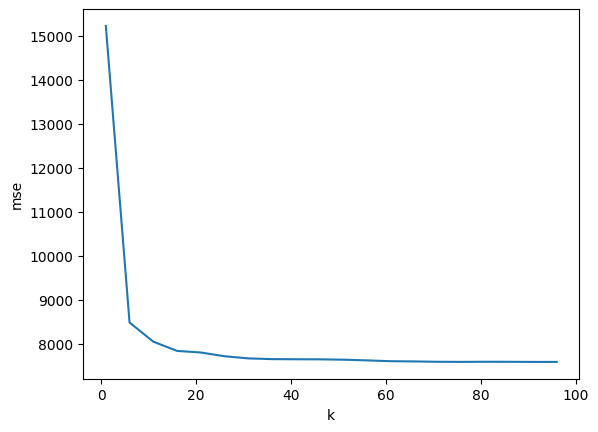

Time taken to train the model:  0.0013594627380371094
Root Mean Squared Error: 9314.63167163207
Best rmse for KNN (sklearn): 9314.63167163207 with k=96


In [18]:
def get_model(param):
    return KNeighborsRegressor(n_neighbors=param)


best_param, params, accuracies = optimize_hyperparameters(get_model, range(1, 100, 5), train, test, val,
                                                          classification=False)
plot_2d(params, accuracies, 'k', 'mse')
best_model = get_model(best_param)

rmse_KNN_sk = test_model(regressor, train, test, classification=False)
print(f"Best rmse for KNN (sklearn): {rmse_KNN_sk} with k={best_param}")


After k ~ 30 there is a clear diminishing return on loss reduction, therefore this k will be used

In [56]:
regressor = ScratchKNeighbors(classification=False, n_neighbors=30)
rmse_KNN_my = test_model(regressor, train, test, classification=False)

Time taken to train the model:  5.0067901611328125e-06
Root Mean Squared Error: 8582.839747518954
